In [7]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

In [2]:
cpu = joblib.cpu_count()

In [3]:
sample = pd.read_pickle("data/scaled/sample.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})
data = Container(data=pd.concat([data.b278, data.b261]))

cls = {name: idx for idx, name in enumerate(data.data.tile.unique())}
data.data["cls"] = data.data.tile.apply(cls.get)

del grouped, sample

cls

{'b261': 1, 'b278': 0}

In [4]:
cls = {v: v for v in cls.values()}

In [10]:
RF_PARAMS = {
    'max_features': None, 'min_samples_split': 10, 'n_jobs': cpu, 
    'criterion': 'entropy', 'n_estimators': 500}

In [15]:
X = data.data[X_columns].values
y = data.data.cls.values

In [16]:
%%time
clf = RandomForestClassifier(**RF_PARAMS)
sel = RFECV(clf, n_jobs=cpu, cv=10)
sel.fit(X, y)

CPU times: user 57min 19s, sys: 25.3 s, total: 57min 44s
Wall time: 15min


In [34]:
df = pd.DataFrame({
    "Feature": X_columns, "Score": sel.grid_scores_, 
    "Selected": sel.support_, "Ranking": sel.ranking_})
df.to_pickle("data/ranking.pkl.bz2", compression="bz2")

In [66]:
print("Selected Features: ", sum(df.Selected.values))

Selected Features:  14


In [65]:
def is_selected(row):
    if row.Selected:
        return pd.Series('background-color: #7EA489', row.index)
    return pd.Series('', row.index)


with pd.option_context('display.precision', 4):
    html = df.sort_values("Ranking").style.apply(is_selected, axis=1)
html

,Feature,Ranking,Score,Selected
28,Meanvariance,1,0.8675,True
26,MaxSlope,1,0.8735,True
27,Mean,1,0.868,True
37,Psi_eta,1,0.865,True
11,Eta_e,1,0.8715,True
17,Freq1_harmonics_amplitude_0,1,0.8685,True
39,Rcs,1,0.8665,True
47,c89_m2,1,0.8685,True
49,cnt,1,0.864,True
50,n09_c3,1,0.8655,True


In [72]:
sX_columns = df[df.Selected].Feature.values

In [73]:
%%time
rf = KFoldExperiment(
    clf=RandomForestClassifier(**RF_PARAMS), clsnum=cls, 
    data=data, pcls=1, ncls=0, X_columns=sX_columns, y_column="cls")
rf = rf("data", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       994
         1.0       0.89      0.86      0.87       998

   micro avg       0.88      0.88      0.88      1992
   macro avg       0.88      0.88      0.87      1992
weighted avg       0.88      0.88      0.87      1992

--------------------------------------------------------------------------------
CPU times: user 5min, sys: 10.2 s, total: 5min 10s
Wall time: 36.1 s


In [77]:
list(sX_columns)

['Beyond1Std',
 'Eta_e',
 'Freq1_harmonics_amplitude_0',
 'LinearTrend',
 'MaxSlope',
 'Mean',
 'Meanvariance',
 'Psi_eta',
 'Rcs',
 'c89_m2',
 'cnt',
 'n09_c3',
 'n09_hk_color',
 'n09_m2']

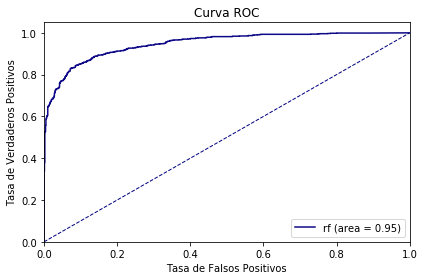

In [75]:
roc({"rf": rf});

In [87]:
dfs = data.data[list(sX_columns) + ["tile"]]

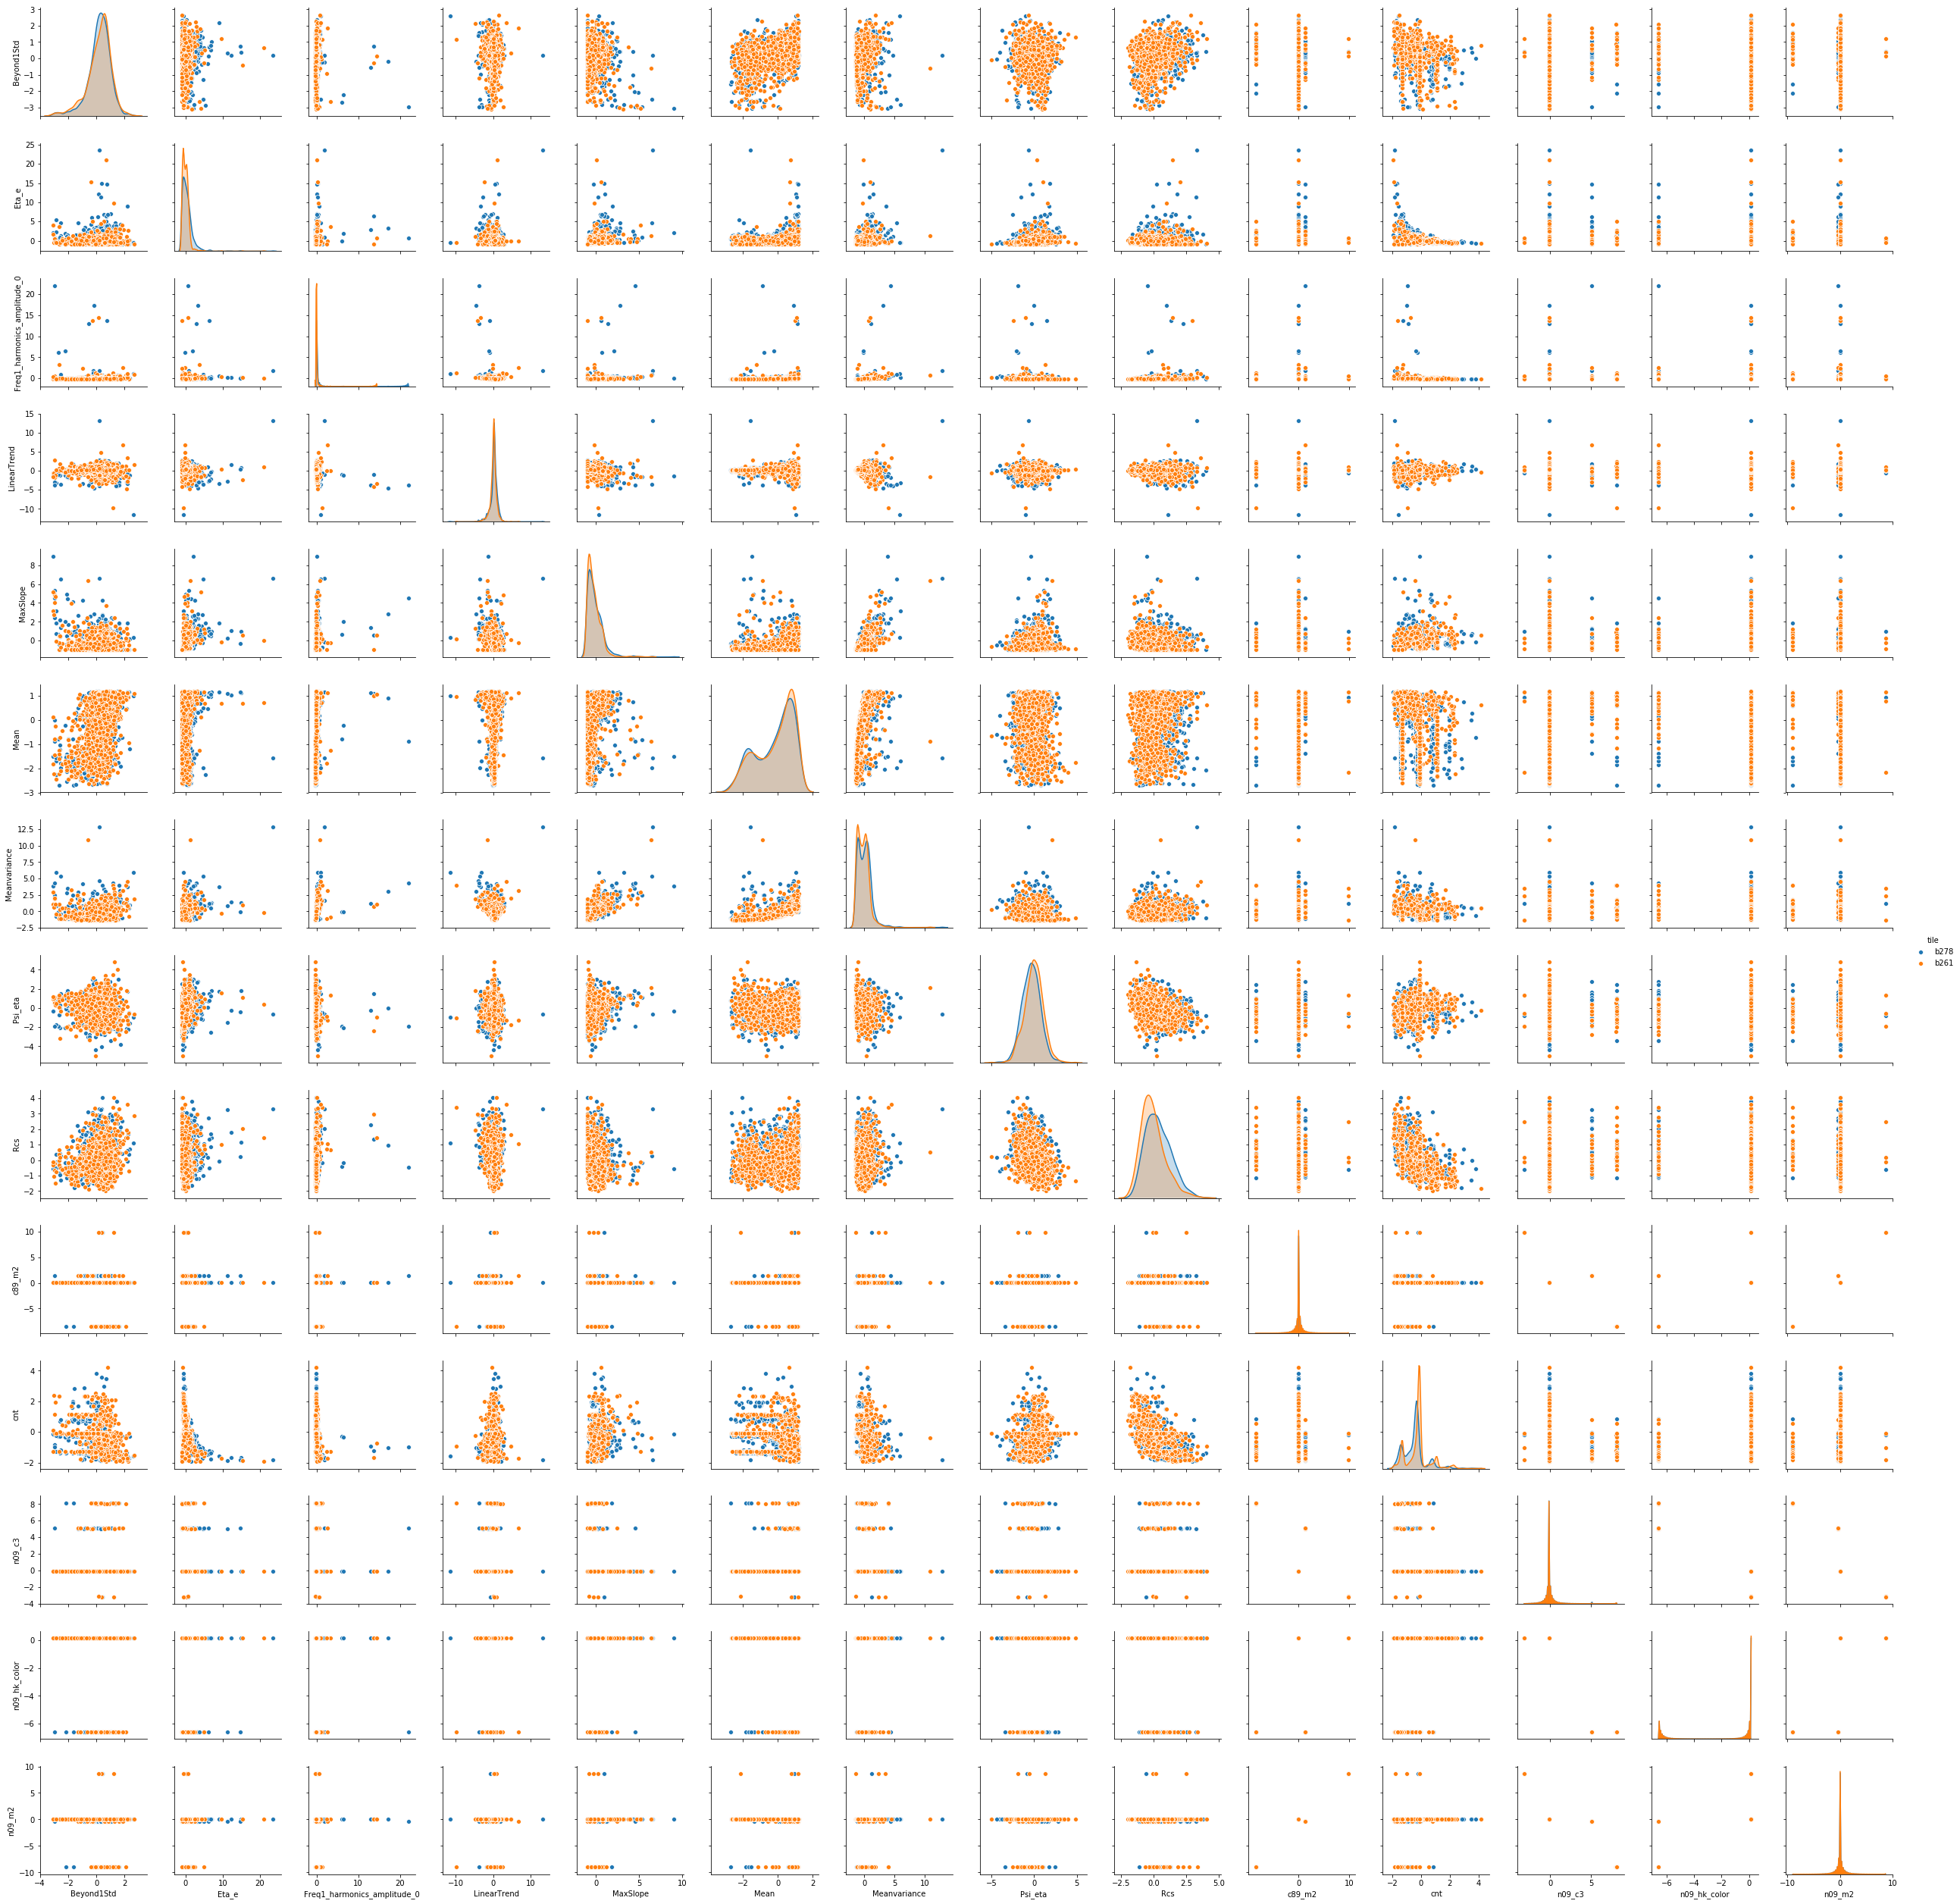

In [89]:
sns.pairplot(dfs, hue="tile")
plt.savefig("vs.pdf")
plt.show()